In [48]:
# import the images from the images folder
import os
import numpy as np

image_paths = []
for filename in os.listdir('images'):
    if filename.endswith(".jpg"):
        image_paths.append(filename)
    else:
        continue

In [49]:
from PIL import Image

images = []

for image_path in image_paths:
    # load the image
    images.append(np.array(Image.open('images/' + image_path)))

In [50]:
from imagecorruptions import corrupt
import tqdm

images_corrupted = []
for image in tqdm.tqdm(images):
    corrupt_amount = np.random.randint(0, 6)
    if corrupt_amount != 0:
        images_corrupted.append(corrupt(image, corruption_name='shot_noise', severity=corrupt_amount))
    else:
        images_corrupted.append(image)


100%|██████████| 2046/2046 [00:34<00:00, 58.81it/s]


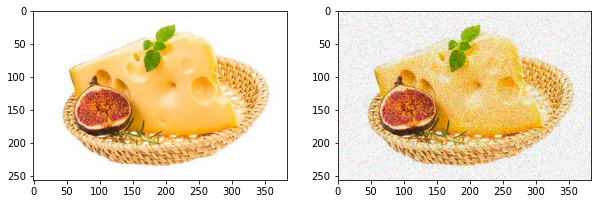

In [51]:
# display 1 of the corrupted images with the original
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.subplot(1, 2, 2)
plt.imshow(images_corrupted[0])


In [52]:
# resize the images to 128x128
from skimage.transform import resize

for i in tqdm.tqdm(range(len(images))):
    images[i] = resize(images[i], (128, 128, 3))
    images_corrupted[i] = resize(images_corrupted[i], (128, 128, 3))

100%|██████████| 2046/2046 [00:28<00:00, 72.46it/s]


In [53]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_corrupted, images, test_size=0.2, random_state=43)

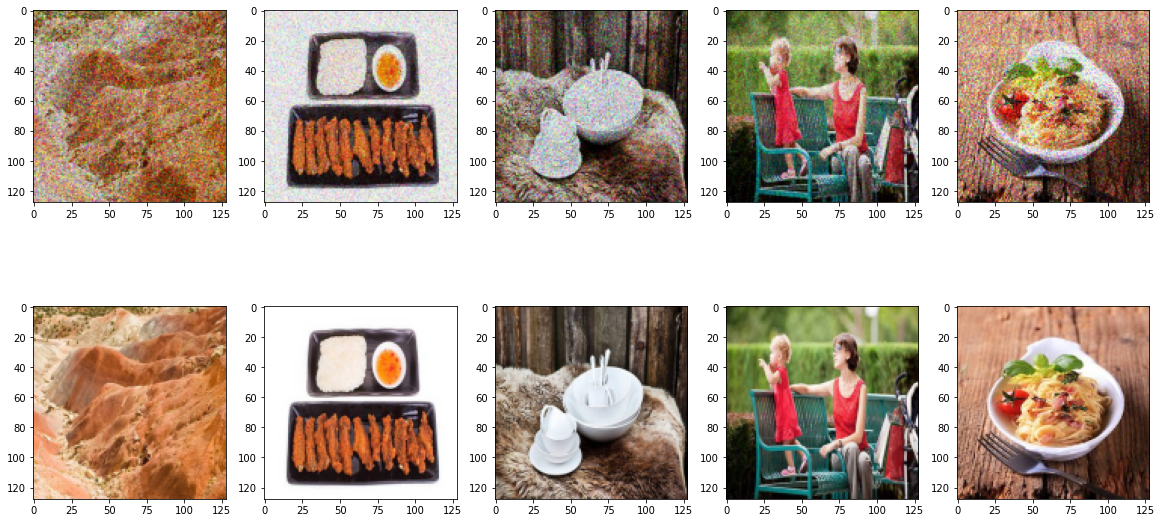

In [57]:
import matplotlib.pyplot as plt

# plot the images and their corrupted versions
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(0, 5):
    axs[0, i].imshow(X_train[i])
    axs[1, i].imshow(y_train[i])
plt.show()


In [125]:
from keras import layers
import keras as ks
from keras.layers import Conv2D, LeakyReLU, MaxPooling2D, UpSampling2D, Input, Dense, Flatten, Reshape, Conv2DTranspose, InputLayer, BatchNormalization
from keras import Model
import tensorflow as tf

def create_autoencoder(input_shape):
    encoder = ks.Sequential()
    encoder.add(InputLayer(input_shape, name='input'))
    encoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'))
    encoder.add(BatchNormalization())
    encoder.add(LeakyReLU())
    encoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'))
    encoder.add(BatchNormalization())
    encoder.add(LeakyReLU())

    decoder = ks.Sequential() 
    decoder.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same', name='deconv1'))
    decoder.add(BatchNormalization())
    decoder.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same', name='deconv2'))
    decoder.add(BatchNormalization())
    decoder.add(Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='deconv5'))
    decoder.add(Reshape(input_shape, name='reshape2'))

    return encoder, decoder

In [129]:
import keras.optimizers as opt

IMG_SHAPE = images[0].shape
encoder, decoder = create_autoencoder(IMG_SHAPE)

inp = layers.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)

optimizer = opt.Adamax(lr=0.002)

autoencoder.compile(optimizer=optimizer, loss='bce')

print(autoencoder.summary())

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_69 (Sequential)  (None, 128, 128, 64)      19776     
                                                                 
 sequential_70 (Sequential)  (None, 128, 128, 3)       225411    
                                                                 
Total params: 245,187
Trainable params: 244,739
Non-trainable params: 448
_________________________________________________________________
None


In [ ]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [130]:
from keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

autoencoder.fit(np.array(X_train), np.array(y_train), epochs=25, batch_size=32, validation_data=(np.array(X_test), np.array(y_test)), callbacks=[tensorboard_callback])


Epoch 1/25
52/52 [==============================] - 14s 264ms/step - loss: 0.4543 - val_loss: 0.6160
Epoch 2/25
52/52 [==============================] - 13s 259ms/step - loss: 0.4288 - val_loss: 0.6197
Epoch 3/25
52/52 [==============================] - 14s 261ms/step - loss: 0.4283 - val_loss: 0.5923
Epoch 4/25
52/52 [==============================] - 14s 263ms/step - loss: 0.4261 - val_loss: 0.5637
Epoch 5/25
52/52 [==============================] - 14s 266ms/step - loss: 0.4244 - val_loss: 0.5304
Epoch 6/25
52/52 [==============================] - 14s 263ms/step - loss: 0.4249 - val_loss: 0.5050
Epoch 7/25
52/52 [==============================] - 14s 269ms/step - loss: 0.4261 - val_loss: 0.4676
Epoch 8/25
52/52 [==============================] - 14s 264ms/step - loss: 0.4261 - val_loss: 0.4660
Epoch 9/25
52/52 [==============================] - 14s 264ms/step - loss: 0.4230 - val_loss: 0.4378
Epoch 10/25
52/52 [==============================] - 14s 264ms/step - loss: 0.4219 - val_lo

1/1 [==============================] - 0s 121ms/step


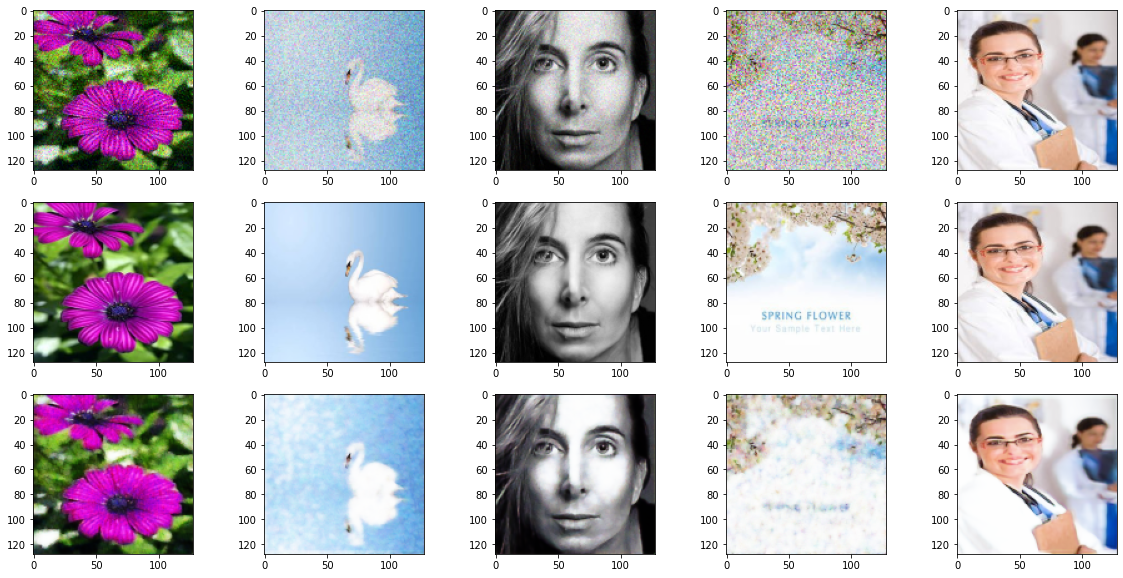

In [131]:
# plot the images and their reconstructed versions
decoded_imgs = autoencoder.predict(np.array(X_test[:5]))

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
for i in range(0, 5):
    axs[0, i].imshow(X_test[i])
    axs[1, i].imshow(y_test[i])
    axs[2, i].imshow(decoded_imgs[i])
plt.show()

